# MLiP - Bengali.AI - Group Sanne de Kleijn

## Libraries

As a first step we need to import some libraries

In [1]:
# We use tensorflow's version of Keras
import os
import pandas as pd
import numpy as np
import PIL.Image
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 

## Loading the dataset
For this notebook we use the Bengali.AI handwritten Grapheme data set from Kaggle \[1\].

In [2]:
# Check the data
for dirname, _, filenames in os.walk('Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the train data
DATA_FOLDER = 'Data/'
train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
train_df.head()

print('train_df shape: ', train_df.shape)

# Load the test data
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
test_df.head()

print('test_df shape: ', test_df.shape)

# Load class map
class_map_df = pd.read_csv(os.path.join(DATA_FOLDER, 'class_map.csv'))
class_map_df.head()

print('class_map_df shape: ', class_map_df.shape)

# Load sample submissions
sample_submission_df = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))
sample_submission_df.head()

print('sample_submission_df shape: ', sample_submission_df.shape)



Data/.DS_Store
Data/class_map.csv
Data/sample_submission.csv
Data/sample_train_image_data_0.parquet
Data/test.csv
Data/test_image_data_0.parquet
Data/test_image_data_1.parquet
Data/test_image_data_2.parquet
Data/test_image_data_3.parquet
Data/train.csv
Data/train_image_data_0.parquet
Data/train_image_data_1.parquet
Data/train_image_data_2.parquet
Data/train_image_data_3.parquet
train_df shape:  (200840, 5)
test_df shape:  (36, 3)
class_map_df shape:  (186, 3)
sample_submission_df shape:  (36, 2)


## Read parquet files

### Read train files

We start with only two files \[1\].

In [3]:
# Read first file
start_time = time.time()
# TODO: use following line for total training
# train_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'train_image_data_0.parquet'))
train_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'sample_train_image_data_0.parquet'))
print(f"`train_image_data_0` read in {round(time.time()-start_time,2)} sec.") 

print('train_0_df shape: ', train_0_df.shape)

print(train_0_df.head())


//anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


`train_image_data_0` read in 39.43 sec.
train_0_df shape:  (5021, 32333)
          image_id    0    1    2    3    4    5    6    7    8  ...  32322  \
index                                                            ...          
2354    Train_2354  254  254  254  253  254  254  254  255  255  ...    255   
46605  Train_46605  248  248  252  253  252  250  251  251  252  ...    252   
41255  Train_41255  252  253  255  255  255  255  255  255  255  ...    251   
25654  Train_25654  255  255  255  255  255  255  255  255  255  ...    251   
10863  Train_10863  244  247  251  249  244  247  252  249  245  ...    254   

       32323  32324  32325  32326  32327  32328  32329  32330  32331  
index                                                                 
2354     255    255    255    255    253    252    253    251    249  
46605    254    254    254    253    254    253    253    253    252  
41255    251    251    251    251    251    251    251    251    251  
25654    253    25

In [23]:
# Read second file
#start_time = time.time()
#train_1_df = pd.read_parquet(os.path.join(DATA_FOLDER,'train_image_data_1.parquet'))
#print(f"`train_image_data_1` read in {round(time.time()-start_time,2)} sec.")  

#print('train_0_df shape: ', train_0_df.shape)

#print(train_0_df.head())

### Read test files

We start with only one test file \[1\].

In [4]:
# Read first test file
start_time = time.time()
test_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'test_image_data_0.parquet'))
print(f"`test_image_data_0` read in {round(time.time()-start_time,2)} sec.")  

print('train_0_df shape: ', train_0_df.shape)

print(train_0_df.head())

`test_image_data_0` read in 47.91 sec.
train_0_df shape:  (5021, 32333)
          image_id    0    1    2    3    4    5    6    7    8  ...  32322  \
index                                                            ...          
2354    Train_2354  254  254  254  253  254  254  254  255  255  ...    255   
46605  Train_46605  248  248  252  253  252  250  251  251  252  ...    252   
41255  Train_41255  252  253  255  255  255  255  255  255  255  ...    251   
25654  Train_25654  255  255  255  255  255  255  255  255  255  ...    251   
10863  Train_10863  244  247  251  249  244  247  252  249  245  ...    254   

       32323  32324  32325  32326  32327  32328  32329  32330  32331  
index                                                                 
2354     255    255    255    255    253    252    253    251    249  
46605    254    254    254    253    254    253    253    253    252  
41255    251    251    251    251    251    251    251    251    251  
25654    253    252

### Data check

We check whether the distribution of the classes matches the kaggle dataset \[1\].

In [5]:
print(f"Train: unique grapheme roots: {train_df.grapheme_root.nunique()}")
print(f"Train: unique vowel diacritics: {train_df.vowel_diacritic.nunique()}")
print(f"Train: unique consonant diacritics: {train_df.consonant_diacritic.nunique()}")
print(f"Train: total unique elements: {train_df.grapheme_root.nunique() + train_df.vowel_diacritic.nunique() + train_df.consonant_diacritic.nunique()}")
print(f"Class map: unique elements: \n{class_map_df.component_type.value_counts()}")
print(f"Total combinations: {pd.DataFrame(train_df.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])).shape[0]}")
      

# TODO: asserts? 

Train: unique grapheme roots: 168
Train: unique vowel diacritics: 11
Train: unique consonant diacritics: 7
Train: total unique elements: 186
Class map: unique elements: 
grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64
Total combinations: 1292


## Inspect grapheme images

We define a function to show a sample of size * size (ex: 5 x 5 = 25) handwritten graphemes \[1\].

In [6]:
def display_image_from_data(data_df, size=5):
    '''
    Display grapheme images from sample data
    param: data_df - sample of data
    param: size - sqrt(sample size of data)
    '''
    plt.figure()
    fig, ax = plt.subplots(size,size,figsize=(12,12))
    # we show grapheme images for a selection of size x size samples
    for i, index in enumerate(data_df.index):
        image_id = data_df.iloc[i]['image_id']
        flattened_image = data_df.iloc[i].drop('image_id').values.astype(np.uint8)
        unpacked_image = PIL.Image.fromarray(flattened_image.reshape(137, 236))

        ax[i//size, i%size].imshow(unpacked_image)
        ax[i//size, i%size].set_title(image_id)
        ax[i//size, i%size].axis('on')

<Figure size 432x288 with 0 Axes>

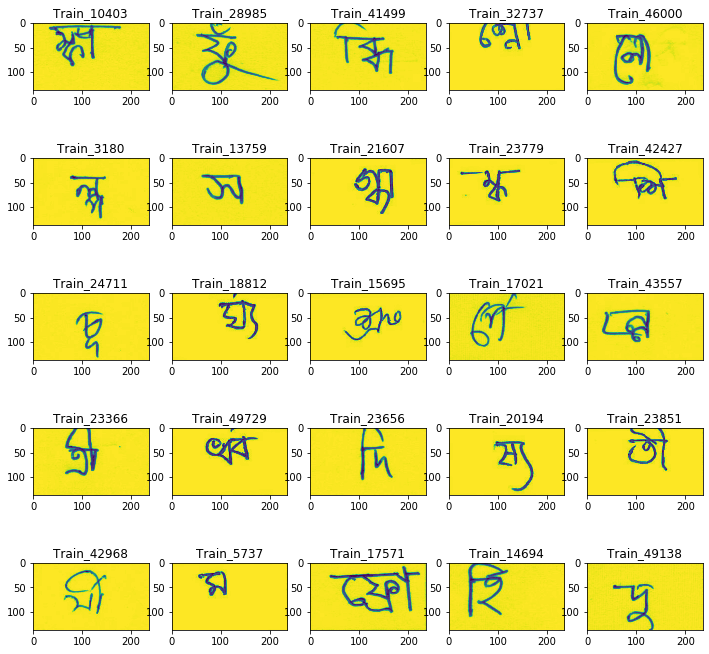

In [7]:
display_image_from_data(train_0_df.sample(25))

We define another function to show the same grapheme in different writing, i.e. to perform sampling (based on variation of grapheme root, vowel diacritic and consonant diacritic, as parameters to the function) \[1\].

In [8]:
def display_writting_variety(data_df=train_0_df, grapheme_root=72, vowel_diacritic=0,\
                             consonant_diacritic=0, size=5):
    '''
    This function get a set of grapheme root, vowel diacritic and consonant diacritic
    and display a sample of 25 images for this grapheme
    param: data_df - the dataset used as source of data
    param: grapheme_root - the grapheme root label
    param: vowel_diacritic - the vowel diacritic label
    param: consonant_diacritic - the consonant diacritic label 
    param: size - sqrt(number of images to show)
    '''
    sample_train_df = train_df.loc[(train_df.grapheme_root == grapheme_root) & \
                                  (train_df.vowel_diacritic == vowel_diacritic) & \
                                  (train_df.consonant_diacritic == consonant_diacritic)]
    print(f"total: {sample_train_df.shape}")
    sample_df = data_df.merge(sample_train_df.image_id.to_frame(), how='inner')
    print(f"total: {sample_df.shape}")
    gr = sample_train_df.iloc[0]['grapheme']
    cm_gr = class_map_df.loc[(class_map_df.component_type=='grapheme_root')& \
                             (class_map_df.label==grapheme_root), 'component'].values[0]
    cm_vd = class_map_df.loc[(class_map_df.component_type=='vowel_diacritic')& \
                             (class_map_df.label==vowel_diacritic), 'component'].values[0]    
    cm_cd = class_map_df.loc[(class_map_df.component_type=='consonant_diacritic')& \
                             (class_map_df.label==consonant_diacritic), 'component'].values[0]    
    
    print(f"grapheme: {gr}, grapheme root: {cm_gr}, vowel discritic: {cm_vd}, consonant diacritic: {cm_cd}")
    # TODO: remove //4 to take bigger sample
    sample_df = sample_df.sample(size//4 * size//4) 
    # Hier staat nu andere text die weg kan
    display_image_from_data(sample_df, size=size)


total: (163, 5)
total: (2, 32333)
grapheme: দাঁ, grapheme root: দ, vowel discritic: া, consonant diacritic: ঁ


<Figure size 432x288 with 0 Axes>

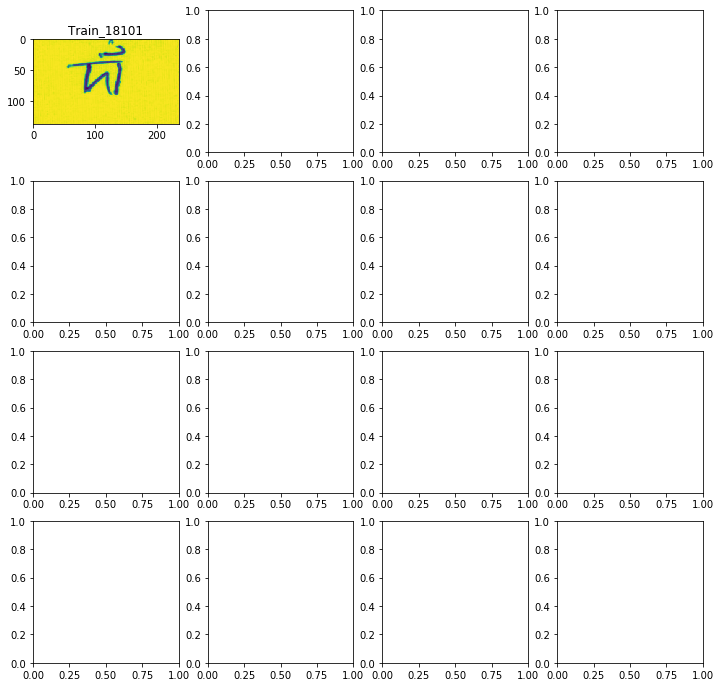

In [29]:
display_writting_variety(train_0_df,72,1,1,4)

## References

\[1\] https://www.kaggle.com/gpreda/bengali-ai-handwritten-grapheme-getting-started Retrieved on: February 18, 2020

# Base Model

In [27]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "//anaconda3/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "//anaconda3/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: dlopen(//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/_pywrap_tensorflow_internal.so, 6): Symbol not found: _SecKeyCopyExternalRepresentation
  Referenced

TypeError: can only concatenate str (not "list") to str

In [ ]:
IMG_SIZE=64
N_CHANNELS=1

inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])